# CV_PROBLEM

### Submitted by
#### Utkarsh Sharma (flamingice2801@gmail.com)

## 1. Load the required libraries

In [5]:
# Importing the basic libraries for data manipulation and vizualization
import numpy as np
import pickle
import os
from sklearn.model_selection import train_test_split
from collections import namedtuple
import matplotlib.pyplot as plt
import pandas as pd

# Deep learning model libraries and utilities
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

## 2. Set the configuration
### This is to make sure that the whole noteboook has same configuration.

In [6]:
#Named Tuple DS is used to set the basic configuration.
Config = namedtuple('Config', ['batch_size', 'image_shape', 'num_classes', 'epochs'])
active_config = Config(32, (28,28,1), 4, 50)

## 3. Define Helper Classes

### 3.1 Define Dataset class
#### The dataset class loads the training and testing dataset and split the training dataset into training and validation sets.

In [7]:
class Dataset():
    DATA_DIR_NAME = 'data'
    TRAINING_IMG_FILENAME = 'training_image.pkl' 
    TRAINING_LABEL_FILENAME = 'training_label.pkl'
    TESTING_IMG_FILENAME = 'testing_image.pkl'
    
    def __init__(self, validation_size=0.1):
        """
        Args:
            validation size: percentage split for validation data
        """
        self.validation_size = validation_size
        self.build()
    
    #Training Set Size
    @property
    def training_set_size(self):
        return len(self.training_images)
    
    #Validation Set Size
    @property
    def validation_set_size(self):
        return len(self.validation_images)
    
    #Test Set Size
    @property
    def test_set_size(self):
        return len(self.test_set)
    
    
    #Loads dataset from disk and split training set
    def build(self):
        self.images = self.load_pickle(os.path.join(self.DATA_DIR_NAME, self.TRAINING_IMG_FILENAME))
        self.labels = self.load_pickle(os.path.join(self.DATA_DIR_NAME, self.TRAINING_LABEL_FILENAME))
        self.training_images, self.validation_images, self.training_labels, self.validation_labels = train_test_split(self.images, self.labels, test_size=self.validation_size, random_state=1)
        
        self.training_set = self.build_set(self.training_images, self.training_labels)
        self.validation_set = self.build_set(self.validation_images, self.validation_labels)
        self.test_set = self.load_pickle(os.path.join(self.DATA_DIR_NAME, self.TESTING_IMG_FILENAME))
    
    #Combines the images with its coresponding labels in one python list
    def build_set(self, images, labels):
        return [images, labels]
        
    #Load pickled dataset files from disk
    def load_pickle(self, filename, mode='rb'):
        data = pickle.load(open(filename, mode))
        data = np.array(data, dtype='float32')
        return data

### Visualize Dataset

Number of images in training set: 7200
Number of images in validation set: 800
Number of images in test set: 2000

-------------------Random Images Sample-------------------


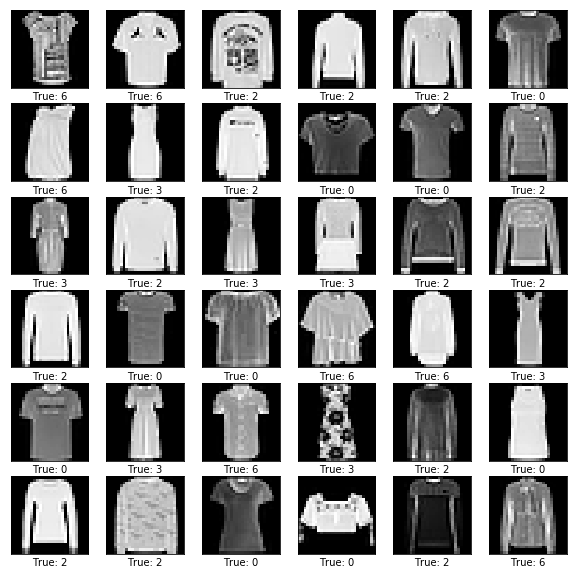

In [8]:
dataset = Dataset()
print("Number of images in training set: {}".format(dataset.training_set_size))
print("Number of images in validation set: {}".format(dataset.validation_set_size))
print("Number of images in test set: {}".format(dataset.test_set_size))

print("\n-------------------Random Images Sample-------------------")
train_set = dataset.training_set
fig, axes = plt.subplots(6, 6 , figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, dataset.training_set_size)
    ax.imshow(train_set[0][idx].reshape(28, 28), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("True: {}".format(np.int32(train_set[1][idx])))

### 3.2 Define Datset Provider class
#### The dataset provider class generates and preprocesses the  data batch during training of the deep learning model.

In [9]:
class DatasetProvider():
    def __init__(self, augment=False, validation_size=0.1, batch_size=None, num_classes=None):
        """
        Args:
            augment: whether to augment data or not
        """
        self.dataset = Dataset(validation_size)
        self.augment = augment
        self.batch_size = batch_size or active_config.batch_size
        self.num_classes = num_classes or active_config.num_classes
    
    #Number of Training Steps
    @property
    def training_steps(self):
        return int(dataset.training_set_size/ self.batch_size)
    
    #Number of Validation Steps
    @property
    def validation_steps(self):
        return int(dataset.test_set_size/ self.batch_size)
    
    #Generate training batch
    def training_set(self):
        for batch in self.generate_batch(self.dataset.training_set):
            yield batch
    
    #Generate validation batch
    def validation_set(self):
        for batch in self.generate_batch(self.dataset.validation_set):
            yield batch
    
    #Generate and preprocess batches
    def generate_batch(self, img_label_set):
        while True:
            all_idx = np.arange(len(img_label_set[0]))
            random_idx = np.random.choice(all_idx, size=self.batch_size)
            random_img = img_label_set[0][random_idx]
            random_label = img_label_set[1][random_idx]
            yield self.preprocess_batch([random_img, random_label])
            
    #Preprocess generated batch
    def preprocess_batch(self, img_label_batch):
        return self.preprocess_images(img_label_batch[0]), self.preprocess_labels(img_label_batch[1])
    
    #Preprocess generated image batch by augmenting images
    def preprocess_images(self, imgs):
        imgs = np.reshape(imgs, (imgs.shape[0], 28, 28, 1))
        if self.augment:
            augmented_images = []
            for img in imgs:
                #Randomly flip the image horizontally
                if np.random.choice([True, False]):
                    img = img[:, ::-1, :]
                
                #Randomly increase or decrease the image brightness
                value = np.random.uniform(0.8, 1.2)
                img = img * value
                img = np.clip(img, a_min=0.0, a_max=255.0)
                
                augmented_images.append(img)
            imgs = np.array(augmented_images)
            
            #Normalize images
#             imgs = imgs/255.
        return imgs
    
    #Preprocess generated labels. As the labels present in the dataset are 0,2,3 and 6, they need to be changed to 0,1,2 and 3. 
    def preprocess_labels(self, labels):
        labels[labels == 2] = 1
        labels[labels == 3] = 2
        labels[labels == 6] = 3
        return to_categorical(labels, num_classes=self.num_classes)

### Vizualize Augmented Images

Batch Size: 32
Batch Shape: (32, 28, 28, 1)

-------------------Random Augmented Images Sample-------------------


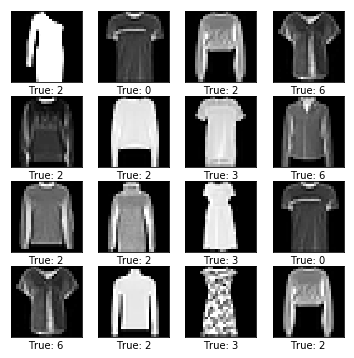

In [10]:
dataset_provider = DatasetProvider(augment=True)
batch = next(dataset_provider.training_set())
print("Batch Size: {}".format(batch[0].shape[0]))
print("Batch Shape: {}".format(batch[0].shape))

print("\n-------------------Random Augmented Images Sample-------------------")
images = batch[0].reshape(len(batch[0]), 28, 28)
labels = np.argmax(batch[1], axis=1)
labels[labels==3] = 6
labels[labels==2] = 3
labels[labels==1] = 2
fig, axes = plt.subplots(4,4 , figsize=(6,6))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, 32)
    ax.imshow(images[idx], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("True: {}".format(np.int32(labels[idx])))

### 3.3 Define ImageClassifierModel class 
#### Image classifier model class defines the model architechture and compiles it.

In [12]:
class ImageClassifierModel():
    
    def __init__(self, learning_rate=0.001, print_summary=False, image_shape=None, num_classes=None):
        """
        Args:
            learning rate: learning rate of the model
            print_summary: whether to print the model architecture summary
            image_shape: shape of input image
            num_classes: number of unique classes in the dataset
        """
        self.image_shape = image_shape or active_config.image_shape
        self.num_classes = num_classes or active_config.num_classes
        self.optimizer = Adam(lr=learning_rate)
        self.print_summary = print_summary
        self.model = self.build()
    
    #Define the model architecture and build it
    #The following model architecture is the final architecture.
    def build(self):
        input_layer = Input(shape=self.image_shape)
        
        x = BatchNormalization()(input_layer)
        x = Conv2D(filters=32, kernel_size=(5,5), padding='same')(x)
        x = Activation('elu')(x)
        x = MaxPooling2D(strides=(2,2))(x)
        x = Dropout(0.3)(x)
        
        x = BatchNormalization()(x)
        x = Conv2D(filters=64, kernel_size=(5,5), padding='same')(x)
        x = Activation('elu')(x)
        x = MaxPooling2D(strides=(2,2))(x)
        x = Dropout(0.3)(x)
        
        x = BatchNormalization()(x)
        x = Conv2D(filters=128, kernel_size=(5,5), padding='same')(x)
        x = Activation('elu')(x)
        x = MaxPooling2D(strides=(2,2))(x)
        x = Dropout(0.3)(x)
        
        x = Flatten()(x)
        x = BatchNormalization()(x)
        x = Dense(units=256)(x)
        x = Activation('elu')(x)
        x = Dropout(0.5)(x)
        output_layer = Dense(units=self.num_classes, activation='softmax')(x)
        
        model = Model(inputs=input_layer, outputs=output_layer)
        
        if self.print_summary:
            print("----------------------------------------------MODEL SUMMARY----------------------------------------------")
            print(model.summary())
        
        model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        
        return model    

### 3.4 Define Training class 
#### The training class makes use of the above defined classes to fit the deep learning model and predicts the classes for the test set.

In [13]:
class Training():
    def __init__(self, augment=False, learning_rate=0.001, print_summary=False, plot_graph=False, epochs=None):
        """
        Args:
            augment: whether to augment the training images
            learning_rate: learing_rate of the model
            print_summary: whether to print the model architecture summary
            plot_graph: whether to plot the model history graph
            epochs: number of epochs
        """
        self.dataset_provider = DatasetProvider(augment)
        self.model = ImageClassifierModel(learning_rate, print_summary).model
        self.epochs = epochs or active_config.epochs
        self.plot_graph = plot_graph
        self.def_callbacks()
    
    #Define model callbacks
    def def_callbacks(self):
        #early stopping callback with val_acc as the monitor parameter
        early_stop = EarlyStopping(monitor='val_acc', min_delta=0.05, patience=10)
        self.callbacks = [early_stop]
    
    #Fit the defined model on training data batches and validate on validation data batches
    def run(self):
        print('\n\n')
        print("----------------------------------------------MODEL VERBOSE----------------------------------------------")
        self.history = self.model.fit_generator(self.dataset_provider.training_set(), 
                                                steps_per_epoch=self.dataset_provider.training_steps, 
                                                epochs=self.epochs, 
                                                validation_data=self.dataset_provider.validation_set(), 
                                                validation_steps=self.dataset_provider.validation_steps,
#                                                 callbacks=self.callbacks
                                               )
        
        
        xtrain, ytrain = self.dataset_provider.dataset.training_set
        xval, yval = self.dataset_provider.dataset.validation_set
        
        #Evaluating model on train and validation datasets
        self.training_evaluation = self.model.evaluate(xtrain.reshape(7200, 28, 28, 1), self.dataset_provider.preprocess_labels(ytrain))
        self.validation_evaluation = self.model.evaluate(xval.reshape(800, 28, 28, 1), self.dataset_provider.preprocess_labels(yval))
        
        print('\n\n')
        print("----------------------------------------------MODEL ACCURACY----------------------------------------------")
        print("Training Loss:{}       Training Accuracy:{}".format(self.training_evaluation[0], self.training_evaluation[1]))
        print("Validation Loss:{}     Validation Accuracy:{}".format(self.validation_evaluation[0], self.validation_evaluation[1]))
        
        #Plot graphs of model history
        if self.plot_graph:
            print('\n\n')
            print("----------------------------------------------MODEL HISTORY----------------------------------------------")
            fig, axes = plt.subplots(1,2, figsize=(15,5))
            axes[0].plot(train.history.history['val_loss'])
            axes[0].plot(train.history.history['loss'])
            axes[0].set_title('Model Loss')
            axes[0].set_ylabel('Loss')
            axes[0].set_xlabel('Epochs')
            axes[0].legend(['val_loss','training_loss'])

            axes[1].plot([i*100 for i in train.history.history['val_acc']])
            axes[1].plot([i*100 for i in train.history.history['acc']])
            axes[1].set_title('Model Accuracy')
            axes[1].set_ylabel('Accuracy')
            axes[1].set_xlabel('Epochs')
            axes[1].legend(['val_acc','training_acc'])
            
    #Predict classes on test_set
    def predict_on_test_set(self):
        test_set = self.dataset_provider.dataset.test_set
        test_set = test_set.reshape(len(test_set), 28, 28, 1)
        
        predictions = self.model.predict(test_set)
        
        return self.decode_predictions(predictions)
    
    #Convert the labels back to 0,2,3 and 6 from 0,1,2 and 3
    def decode_predictions(self, predictions):
        pred = np.argmax(predictions, axis=1)
        
        pred[pred == 3] = 6
        pred[pred == 2] = 3
        pred[pred == 1] = 2
        
        return pred

### Final Approach: Updated Final Model and this is byfar the most accurate one

Problem with previous models: 
1. 'ReLu' Activation: It does not work if x is negative. It will simply make the activation zero.
2. No Batch Normalization

Changes made:
1. Changed the activation to 'elu'. ELU activation tends to converge the loss to zero more rapidly with more accurate results. It can also produce negative outputs unlike relu.
2. Added batch normalization after every layer to normalize the activations which will reduce the time to reach local minima.

The following implementation is the final model.
        
        input_layer = Input(shape=self.image_shape)
        
        x = BatchNormalization()(input_layer)
        x = Conv2D(filters=32, kernel_size=(5,5), padding='same')(x)
        x = Activation('elu')(x)
        x = MaxPooling2D(strides=(2,2))(x)
        x = Dropout(0.3)(x)
        
        x = BatchNormalization()(x)
        x = Conv2D(filters=64, kernel_size=(5,5), padding='same')(x)
        x = Activation('elu')(x)
        x = MaxPooling2D(strides=(2,2))(x)
        x = Dropout(0.3)(x)
        
        x = BatchNormalization()(x)
        x = Conv2D(filters=128, kernel_size=(5,5), padding='same')(x)
        x = Activation('elu')(x)
        x = MaxPooling2D(strides=(2,2))(x)
        x = Dropout(0.3)(x)
        
        x = Flatten()(x)
        x = BatchNormalization()(x)
        x = Dense(units=256)(x)
        x = Activation('elu')(x)
        x = Dropout(0.5)(x)
        output_layer = Dense(units=self.num_classes, activation='softmax')(x)

----------------------------------------------MODEL SUMMARY----------------------------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
____________________________________

225/225 [==============================] - 3s 11ms/step - loss: 0.2448 - acc: 0.9058 - val_loss: 0.3650 - val_acc: 0.8745
Epoch 37/50
225/225 [==============================] - 3s 12ms/step - loss: 0.2509 - acc: 0.9056 - val_loss: 0.3504 - val_acc: 0.8866
Epoch 38/50
225/225 [==============================] - 3s 11ms/step - loss: 0.2243 - acc: 0.9146 - val_loss: 0.3403 - val_acc: 0.8821
Epoch 39/50
225/225 [==============================] - 3s 11ms/step - loss: 0.2051 - acc: 0.9206 - val_loss: 0.3663 - val_acc: 0.8805
Epoch 40/50
225/225 [==============================] - 3s 11ms/step - loss: 0.1970 - acc: 0.9242 - val_loss: 0.3330 - val_acc: 0.8891
Epoch 41/50
225/225 [==============================] - 3s 12ms/step - loss: 0.2254 - acc: 0.9163 - val_loss: 0.3777 - val_acc: 0.8725
Epoch 42/50
225/225 [==============================] - 3s 11ms/step - loss: 0.2188 - acc: 0.9168 - val_loss: 0.3474 - val_acc: 0.8906
Epoch 43/50
225/225 [==============================] - 3s 11ms/step - loss

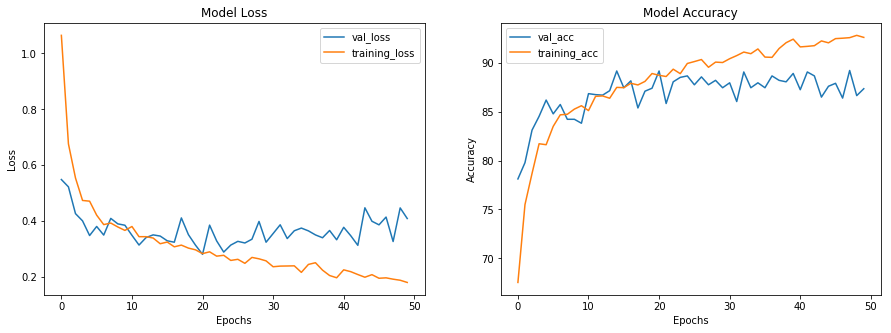

In [14]:
train = Training(augment=True, print_summary=True, plot_graph=True)
train.run()

## Prediction on test set

In [16]:
predictions = train.predict_on_test_set()
image_index = np.arange(0, len(predictions))

In [17]:
#Define a dataframe with image_index and class as headers and save it to a .csv file
df = pd.DataFrame(data={'image_index':image_index, 'class':predictions})
df.to_csv('Utkarsh_Sharma.csv', index=False)

In [20]:
#Optional: Save the model
train.model.save('model.h5')